# Segmentación de radiografías pulmonares
Nombre: Daniel Psijas


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import os


import PIL.Image


2024-08-17 22:09:01.740768: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 22:09:02.282301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 22:09:03.256048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 1. Lectura de datos y creación de pipeline ###

Leer el dataset y asociar cada radiografía x con la máscara y. Dividir en train y test.

In [3]:
def get_dataset(x_dir, y_dir):
    x_files = sorted([f for f in os.listdir(x_dir) if f.endswith('.png')])  
    y_files = sorted([f for f in os.listdir(y_dir) if f.endswith('.png')])

    # Filtrar archivos que no coinciden
    x_files = [x_file for x_file in x_files if x_file in y_files]
    y_files = [y_file for y_file in y_files if y_file in x_files]

    # Dividir en conjunto de entrenamiento 80% y prueba 20%
    x_train, x_test, y_train, y_test = train_test_split(x_files, y_files, test_size=0.2, random_state=42)
    
    # Emparejar archivos por nombre (asumiendo que los nombres son únicos y coinciden)
    x_train = [os.path.join(x_dir, x_file) for x_file in x_train if x_file in y_train]
    x_test = [os.path.join(x_dir, x_file) for x_file in x_test if x_file in y_test]

    y_train = [os.path.join(y_dir, y_file) for y_file in y_train]
    y_test = [os.path.join(y_dir, y_file) for y_file in y_test]
    return x_train, x_test, y_train, y_test

Pipeline con funciones de tensorflow para procesar las imagenes de forma eficiente durante el
entrenamiento.

In [4]:
# Leer y preprocesar radiografías
def preprocess_X(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)  # 3 canales RGB
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [128, 128]) # 128x128
    image = image / 255.0  # Normalizar
    return image

# Leer y preprocesar máscaras
def preprocess_Y(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1) # 1 canal (escala de grises) 
    image.set_shape([None, None, 1]) 
    image = tf.image.resize(image, [128, 128]) # 128x128
    image = image / 255.0  # Normalizar
    return image

# Crear pipeline para los datos de train y test
def load_dataset(x_dir, y_dir):
    # Rutas
    x_train_paths, x_test_paths, y_train_paths, y_test_paths = get_dataset(x_dir,y_dir)

    # Crear datasets con tensorflow y preprocesarlos con las funciones 
    x_train = tf.data.Dataset.from_tensor_slices(x_train_paths)
    x_train = x_train.map(preprocess_X, num_parallel_calls=tf.data.AUTOTUNE)

    y_train = tf.data.Dataset.from_tensor_slices(y_train_paths)
    y_train = y_train.map(preprocess_Y, num_parallel_calls=tf.data.AUTOTUNE)

    x_test = tf.data.Dataset.from_tensor_slices(x_test_paths)
    x_test = x_test.map(preprocess_X, num_parallel_calls=tf.data.AUTOTUNE)

    y_test = tf.data.Dataset.from_tensor_slices(y_test_paths)
    y_test = y_test.map(preprocess_Y, num_parallel_calls=tf.data.AUTOTUNE)

    train = tf.data.Dataset.zip((x_train, y_train))
    train = train.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

    test = tf.data.Dataset.zip((x_test, y_test))
    test = test.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
    return train,test

In [5]:
train, test = load_dataset('./LungsX', './LungsY') # Cargar train y test

### 2. Funciones de apoyo ##

Generar la imagen a mostrar superponiendo la máscara predicha con la máscara real

In [7]:
def output_image(y_test, y_pred):
    # Pasando las imagenes a 1 si el valor es mayor que 0.5, y 0 si no
    # para comparar mediante condiciones las máscaras predichas y reales
    y_test_bin = tf.cast(y_test > 0.5, tf.float32)
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)


    # Convertir a arrays NumPy si es necesario
    y_test_bin = y_test_bin.numpy().squeeze() 
    y_pred_bin = y_pred_bin.numpy().squeeze() 

    
    # Crear la imagen de superposición
    combined = np.zeros((y_test_bin.shape[0], y_test_bin.shape[1], 3), dtype=np.uint8)

    # Crear las máscaras de color para verde, rojo y amarillo
    combined[(y_test_bin == 1) & (y_pred_bin == 1)] = [255, 255, 0]  # Amarillo si coinciden
    combined[(y_test_bin == 1) & (y_pred_bin == 0)] = [0, 255, 0]    # Verde si la predicha sobra
    combined[(y_pred_bin == 1) & (y_test_bin == 0)] = [255, 0, 0]    # Rojo si a la predicha le faltó 

    return combined


Plotear las imagenes de entrada y salida.

In [140]:
def show_images(x_test,y_test,y_pred,dices,n):

    

    for i in range(x_test.shape[0]):
        
        j = i%n
        if(j == 0):
            plt.figure(figsize=(12, n))
            fig, axes = plt.subplots(2, n, figsize=(n, 2))
        
        axes[0,j].set_title(f'Dice: {dices[i]:.2f}')
        # Imagen original
        axes[0, j].imshow(x_test[i])
        axes[0, j].axis('off')  # Ocultar los ejes
    
        # Salida del modelo predicha junto con la salida real
        axes[1, j].imshow(x_test[i])
        axes[1, j].imshow(output_image(y_test[i], y_pred[i]),alpha=0.5)
        axes[1, j].axis('off')  # Ocultar los ejes

        if(j == n-1):
            plt.tight_layout()
            plt.show()




### 3. Modelos U-Net ###

In [59]:

def unet_model(optimizer):
    # Input Layer - entrada de la imagen con las dimensiones especificadas (128x128 con 3 canales de color)
    inputs = tf.keras.layers.Input((128, 128, 3))

    # Downsampling
    # c1: Primera capa convolucional en el encoder
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)  # Dropout para regularización
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)  # MaxPooling para reducir la dimensionalidad

    # c2: Segunda capa convolucional en el encoder
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    # c3: Tercera capa convolucional en el encoder
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    # c4: Cuarta capa convolucional en el encoder
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    # c5: Capa más profunda (bottleneck) de la red
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Upsampling
    # u6: Primera capa de upsampling
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])  # Concatenación con la capa correspondiente del encoder
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    # u7: Segunda capa de upsampling
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    # u8: Tercera capa de upsampling
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    # u9: Cuarta capa de upsampling
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    # Compilar con loss de entropía cruzada, y tomar las medidas de accuracy y dice de keras
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.losses.Dice])
    return model






In [60]:
# Graficar los resultados
def plot_history(train,test,metric):

    plt.figure(figsize=(8, 6))
    plt.plot(train, label=metric + ' de train')
    plt.plot(test, label=metric + ' de validación')
    plt.title(metric + ' durante el entrenamiento')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### 5. Entrenamiento ###

In [61]:
model = unet_model('adam')

history = model.fit(train, epochs=10,validation_data=test)



Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 855ms/step - accuracy: 0.5250 - dice: 0.6690 - loss: 0.7016 - val_accuracy: 0.7416 - val_dice: 0.7318 - val_loss: 0.5673
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 862ms/step - accuracy: 0.7375 - dice: 0.7256 - loss: 0.5703 - val_accuracy: 0.7416 - val_dice: 0.7111 - val_loss: 0.5476
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 872ms/step - accuracy: 0.7360 - dice: 0.7072 - loss: 0.5358 - val_accuracy: 0.7416 - val_dice: 0.6649 - val_loss: 0.5374
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 850ms/step - accuracy: 0.7359 - dice: 0.6289 - loss: 0.4583 - val_accuracy: 0.7416 - val_dice: 0.5887 - val_loss: 0.4126
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 913ms/step - accuracy: 0.7405 - dice: 0.5607 - loss: 0.3836 - val_accuracy: 0.7416 - val_dice: 0.5576 - val_loss: 0.3864
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 916ms/step - accuracy: 0.7609 - dice: 0.5198 - loss: 0.3521 - val_accuracy: 0.8874 - val_dice: 0.4660 - val_loss: 0.3277
Epoch 7/10
10/10 ━━━━━

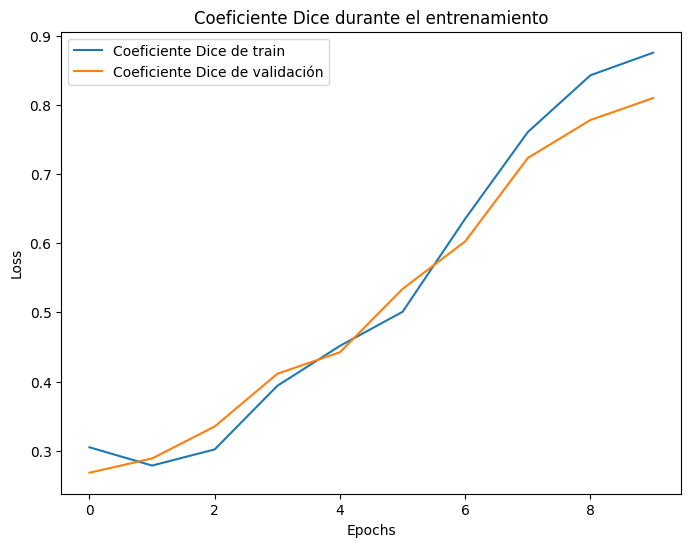

In [62]:
# Pasando los losses dice a dices normales restandoles a 1
dices = list(1 - history.history['dice'][i] for i in range(len(history.history['dice'])))
val_dices = list(1 - history.history['val_dice'][i] for i in range(len(history.history['val_dice'])))

plot_history(dices,val_dices,'Coeficiente Dice')

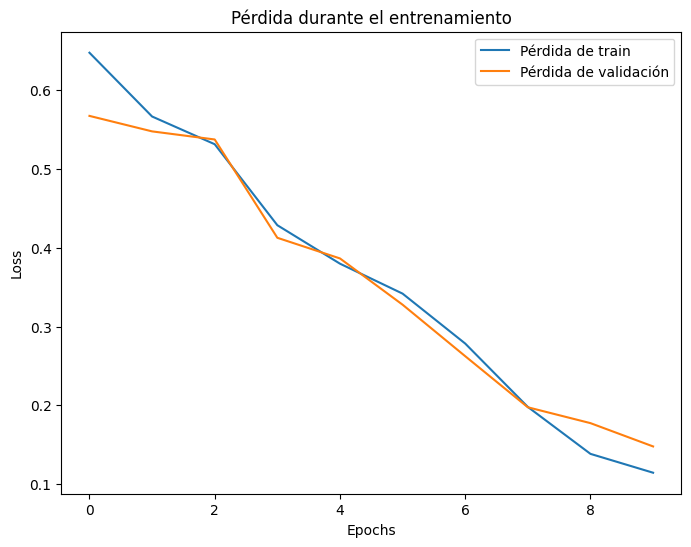

In [63]:

plot_history(history.history['loss'],history.history['val_loss'],'Pérdida')

In [67]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy, test_dice = model.evaluate(test)

# Predecir el conjunto de prueba
y_pred = model.predict(test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9393 - dice: 0.1890 - loss: 0.1456
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


In [68]:

x = []
y = []
# Pasar los datos de test del batch a arrays de numpy
for batch in test:
    image, mask = batch
    x.append(image.numpy())
    y.append(mask.numpy())

x_test = np.concatenate(x, axis=0)
y_test = np.concatenate(y, axis=0)

2024-08-18 01:14:53.167884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
def dice(y_true, y_pred):
    return (2 * sum(y_true * y_pred)) / (sum(y_true) + sum(y_pred))

In [95]:
test_dices = list(tf.get_static_value(dice(y_test, y_pred)) for y_test, y_pred in zip(y_test, y_pred))
data = list(range(1,len(test_dices)+1))


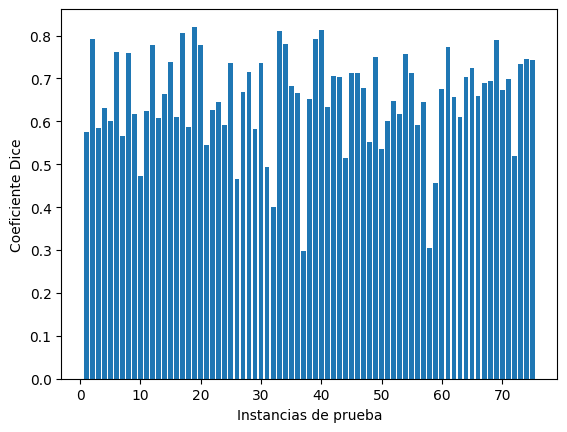

In [96]:
plt.bar(data,test_dices)
plt.xlabel('Instancias de prueba')
plt.ylabel('Coeficiente Dice')
plt.show()

In [107]:
worst = np.array(sorted(test_dices.copy()))[:5]
best = np.array(sorted(test_dices.copy()))[-5:]

In [108]:
best

array([0.7929651, 0.8049151, 0.8111277, 0.8126011, 0.8205331],
      dtype=float32)

In [109]:
worst

array([0.29685062, 0.30553293, 0.40016925, 0.45658398, 0.46636254],
      dtype=float32)

In [123]:
indices_best = list(np.where(test_dices == value) for value in best) 
indices_worst = list(np.where(test_dices == value) for value in worst)

In [127]:
test_dices = np.array(test_dices)
y_pred = np.array(y_pred)

### Mejores 5 ###


<Figure size 1200x500 with 0 Axes>

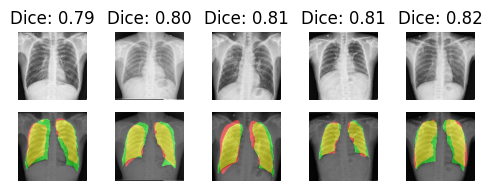

In [142]:
show_images(x_test[indices_best].squeeze(),y_test[indices_best].squeeze(),y_pred[indices_best].squeeze(),test_dices[indices_best].squeeze(),5)

### Peores 5 ###

<Figure size 1200x500 with 0 Axes>

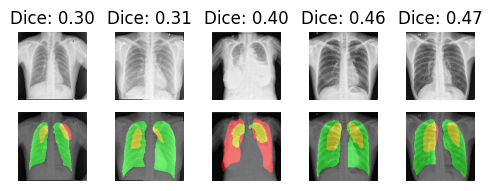

In [143]:
show_images(x_test[indices_worst].squeeze(),y_test[indices_worst].squeeze(),y_pred[indices_worst].squeeze(),test_dices[indices_worst].squeeze(),5)

### Todas las instancias ###

<Figure size 1200x500 with 0 Axes>

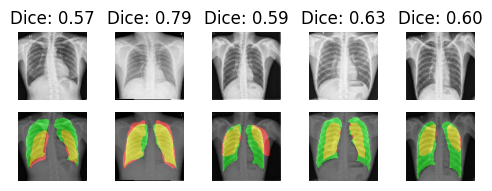

<Figure size 1200x500 with 0 Axes>

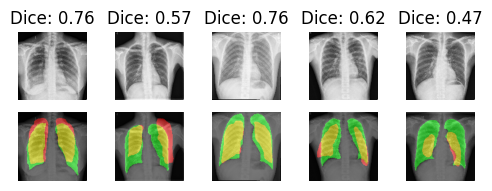

<Figure size 1200x500 with 0 Axes>

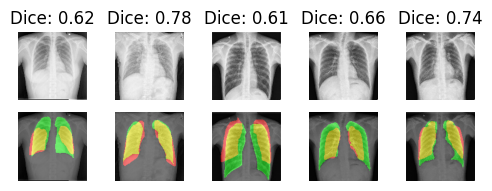

<Figure size 1200x500 with 0 Axes>

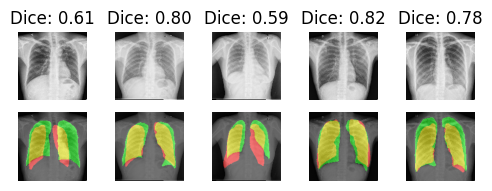

<Figure size 1200x500 with 0 Axes>

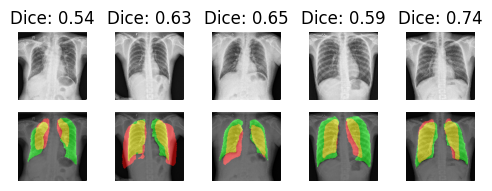

<Figure size 1200x500 with 0 Axes>

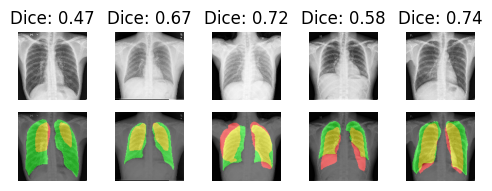

<Figure size 1200x500 with 0 Axes>

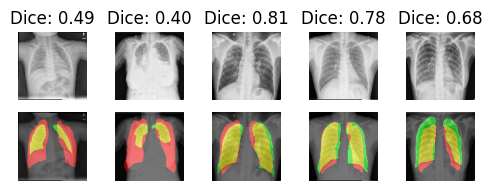

<Figure size 1200x500 with 0 Axes>

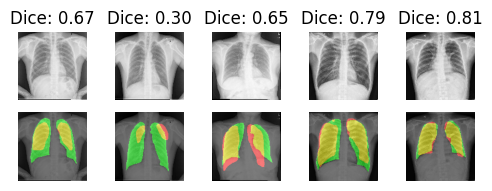

<Figure size 1200x500 with 0 Axes>

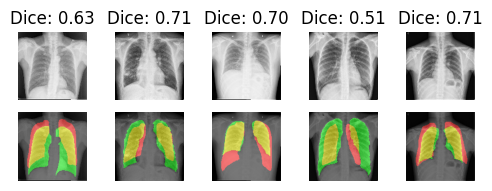

<Figure size 1200x500 with 0 Axes>

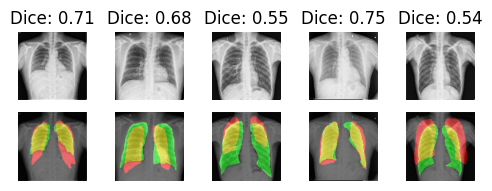

<Figure size 1200x500 with 0 Axes>

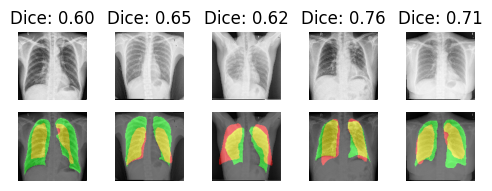

<Figure size 1200x500 with 0 Axes>

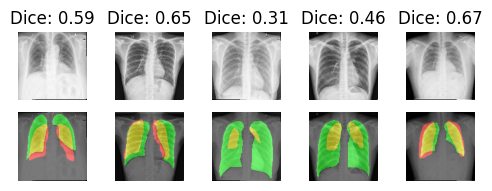

<Figure size 1200x500 with 0 Axes>

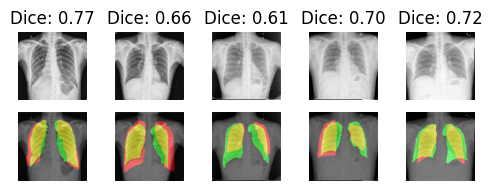

<Figure size 1200x500 with 0 Axes>

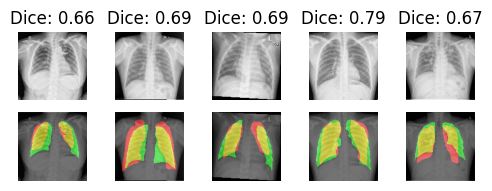

<Figure size 1200x500 with 0 Axes>

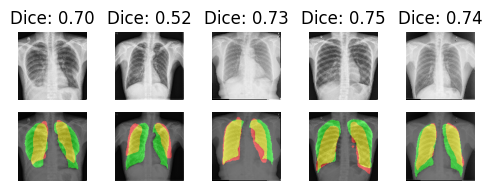

In [118]:
show_images(x_test,y_test,y_pred,test_dices,5)